In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
from utils.preprocess import load_ninapro_data, preprocess_emg
dataPath = parentDir / "data" / "raw" / "ninapro-db2"

In [94]:
subject_number = 25
exercise_number = 1
channel_to_plot = 2

saveFigs = True

In [41]:
emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)
filtered_emg = preprocess_emg(emg[:, channel_to_plot], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

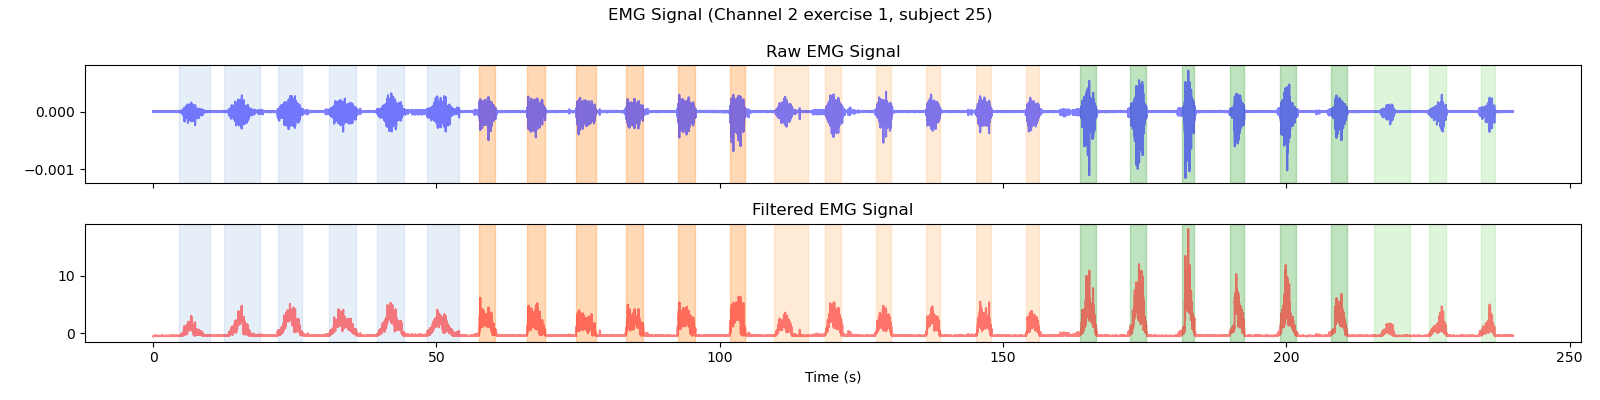

In [42]:
 # Plot raw and filtered EMG signals for comparison

plot_startTime = 0  # in seconds
plot_endTime = 240   # in seconds

start_index = int(plot_startTime * Fs)
end_index = int(plot_endTime * Fs)
unique_gestures = np.unique(stimulus)

fig, axs = plt.subplots(2,1, figsize=((plot_endTime - plot_startTime)/15, 4), sharex=True)
axs[0].plot(time[start_index:end_index], emg[start_index:end_index, channel_to_plot], color='blue', label='Raw EMG', alpha=0.5)
axs[1].plot(time[start_index:end_index], filtered_emg[start_index:end_index], color='red', label='Filtered EMG', alpha=0.5)
plt.suptitle(f'EMG Signal (Channel {channel_to_plot} exercise {exercise_number}, subject {subject_number})')
plt.xlabel('Time (s)')
axs[0].set_title('Raw EMG Signal')
axs[1].set_title('Filtered EMG Signal')

# Plot all gesture repetitions
for gesture_id in unique_gestures:
    if gesture_id == 0:
            continue # Skip rest gesture
    for repetition_id in range(1, 7):  #6 repetitions
        # Find start and end indices of the gesture repetition
        mask = (stimulus == gesture_id) & (repetition == repetition_id)
        if np.any(mask):
            start_idx = np.where(mask)[0][0]
            end_idx = np.where(mask)[0][-1]
            ## Skip spans that are completely outside the plotted window
            if end_idx < start_index or start_idx > end_index - 1:
                continue
            # Clamp to the plotting window
            start_idx = max(start_idx, start_index)
            end_idx   = min(end_idx,   end_index - 1)
        axs[0].axvspan(time[start_idx], time[end_idx], color=plt.cm.tab20(gesture_id % 20), alpha=0.3, label=f' {gesture_id}')
        axs[1].axvspan(time[start_idx], time[end_idx], color=plt.cm.tab20(gesture_id % 20), alpha=0.3, label=f' {gesture_id}')
# plt.ylabel('Amplitude')
# plt.legend()
plt.tight_layout()
if saveFigs:    
    plt.savefig(parentDir / "results" / "figures" / f"emg_preprocessing_subject{subject_number}_exercise{exercise_number}_channel{channel_to_plot}.png", dpi=300)
plt.show()

In [ ]:

gesture_durations_df = pd.DataFrame(columns=["Subject", "Gesture", "Repetition", "Duration"])
gesture_durations = []
emg_clean = np.zeros_like(emg)
windowTimeS = 1  # in seconds

# Go through all subjects and save duration of each gesture and each repetition
for subject_number in range(1,41):
    print(f"Processing subject {subject_number}...")
    
    emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)
    emg_clean = np.zeros_like(emg)

    for ch in range(emg.shape[1]):
        emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)
    for gesture in np.unique(stimulus):
        if gesture == 0:
            continue
        for rep in range(1, 7):
            indices = np.where((stimulus == gesture) & (repetition == rep))[0]
            if len(indices) == 0:
                continue
            # duration = time[indices[-1]] - time[indices[0]]
            duration = len(indices) / Fs  # in seconds
            gesture_durations.append({"Subject": subject_number, "Gesture": gesture, "Repetition": rep, "Duration": duration})
            # Epoch data for each gesture and repetition for ML purposes
            

gesture_durations_df = pd.DataFrame(gesture_durations)
gesture_durations_df.to_csv(parentDir / "data" / "processed" / "gesture_durations.csv", index=False)

Processing subject 1...
Processing subject 2...
Processing subject 3...
Processing subject 4...
Processing subject 5...
Processing subject 6...
Processing subject 7...
Processing subject 8...
Processing subject 9...
Processing subject 10...
Processing subject 11...
Processing subject 12...
Processing subject 13...
Processing subject 14...
Processing subject 15...
Processing subject 16...
Processing subject 17...
Processing subject 18...
Processing subject 19...
Processing subject 20...
Processing subject 21...
Processing subject 22...
Processing subject 23...
Processing subject 24...
Processing subject 25...
Processing subject 26...
Processing subject 27...
Processing subject 28...
Processing subject 29...
Processing subject 30...
Processing subject 31...
Processing subject 32...
Processing subject 33...
Processing subject 34...
Processing subject 35...
Processing subject 36...
Processing subject 37...
Processing subject 38...
Processing subject 39...
Processing subject 40...


/var/folders/__/cj7mp8_x5y1_sxsmfdv5pyv00000gn/T/ipykernel_33482/2227720549.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gesture", y="Duration", data=gesture_durations_df, palette="Set2")
/var/folders/__/cj7mp8_x5y1_sxsmfdv5pyv00000gn/T/ipykernel_33482/2227720549.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


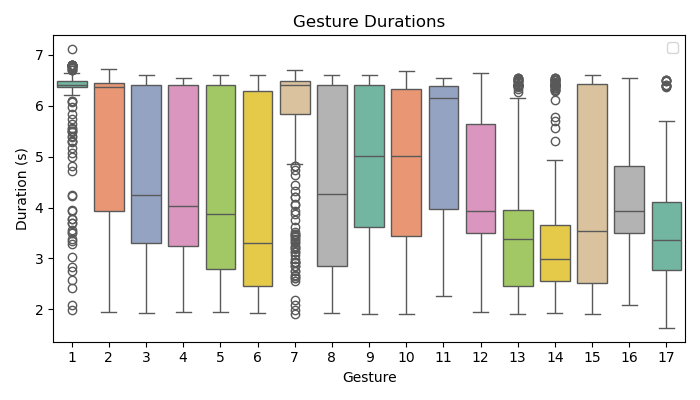

In [95]:
# Plot durations per gesture as a box plot
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.boxplot(x="Gesture", y="Duration", data=gesture_durations_df, palette="Set2")
plt.xlabel('Gesture')
plt.ylabel('Duration (s)')
plt.title('Gesture Durations')
plt.tight_layout()
plt.legend()
plt.tight_layout()
if saveFigs:    
    plt.savefig(parentDir / "results" / "figures" / f"gesture_durations_summary.png", dpi=300)
plt.show()

In [92]:
# Plot cleaned average emg traces for each gesture for a given subject, exercise, and channel
subject_number = 28
exercise_number = 1
gesture_to_plot = 6
channel_to_plot = 5
duration_s = 3  # seconds

emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)
filtered_emg = preprocess_emg(emg[:, channel_to_plot], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

emg_repetitions = np.zeros((0, int(duration_s * Fs)))  # Initialize empty array for storing epochs
for repetition_id in range(1, 7):  #6 repetitions
    # Find start and end indices of the gesture repetition
    mask = (stimulus == gesture_to_plot) & (repetition == repetition_id)
    if np.any(mask):
        start_idx = np.where(mask)[0][0]
        end_idx = np.where(mask)[0][-1]
        if end_idx - start_idx < int(duration_s * Fs):
            continue  # Skip if the gesture duration is less than desired duration
        # Clamp to desired duration
        end_idx = start_idx + int(duration_s * Fs)
        epoch_time = time[start_idx:end_idx] - time[start_idx]
        epoch_emg = filtered_emg[start_idx:end_idx]
        emg_repetitions = np.vstack((emg_repetitions, epoch_emg[np.newaxis, :]))  # Add new epoch

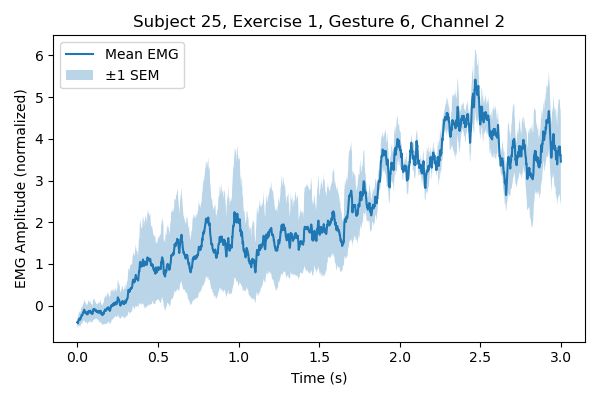

In [103]:
# Plot mean and sem of the emg repetitions
mean_emg = np.mean(emg_repetitions, axis=0)
sem_emg = np.std(emg_repetitions, axis=0) / np.sqrt(emg_repetitions.shape[0])
plt.figure(figsize=(6, 4))
plt.plot(epoch_time, mean_emg, label='Mean EMG')
plt.fill_between(epoch_time, mean_emg - sem_emg, mean_emg + sem_emg, alpha=0.3, label='±1 SEM')
plt.title(f'Subject {subject_number}, Exercise {exercise_number}, Gesture {gesture_to_plot}, Channel {channel_to_plot}')
plt.xlabel('Time (s)')
plt.ylabel('EMG Amplitude (normalized)')
plt.legend()
plt.tight_layout()
# if saveFigs:    
#     plt.savefig(parentDir / "results" / "figures" / f"emg_average_subject{subject_number}_exercise{exercise_number}_gesture{gesture_to_plot}_channel{channel_to_plot}.png", dpi=300)
plt.show()

In [104]:
# Plot cleaned average emg traces for each gesture for all subjects (1 trace for each subject), exercise, and channel
exercise_number = 1
gesture_to_plot = 6
channel_to_plot = 5
duration_s = 3  # seconds

emg_mean_subject = np.zeros((41, int(duration_s * Fs)))  
for subject_number in range(1,41):
    print(f"Processing subject {subject_number}...")
    emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)
    filtered_emg = preprocess_emg(emg[:, channel_to_plot], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

    emg_repetitions = np.zeros((0, int(duration_s * Fs)))  # Initialize empty array for storing epochs
    for repetition_id in range(1, 7):  #6 repetitions
        # Find start and end indices of the gesture repetition
        mask = (stimulus == gesture_to_plot) & (repetition == repetition_id)
        if np.any(mask):
            start_idx = np.where(mask)[0][0]
            end_idx = np.where(mask)[0][-1]
            if end_idx - start_idx < int(duration_s * Fs):
                continue  # Skip if the gesture duration is less than desired duration
            # Clamp to desired duration
            end_idx = start_idx + int(duration_s * Fs)
            epoch_time = time[start_idx:end_idx] - time[start_idx]
            epoch_emg = filtered_emg[start_idx:end_idx]
            emg_repetitions = np.vstack((emg_repetitions, epoch_emg[np.newaxis, :]))  # Add new epoch
    if emg_repetitions.shape[0] > 0:
        emg_mean_subject[subject_number-1, :] = np.mean(emg_repetitions, axis=0)

Processing subject 1...
Processing subject 2...
Processing subject 3...
Processing subject 4...
Processing subject 5...
Processing subject 6...
Processing subject 7...
Processing subject 8...
Processing subject 9...
Processing subject 10...
Processing subject 11...
Processing subject 12...
Processing subject 13...
Processing subject 14...
Processing subject 15...
Processing subject 16...
Processing subject 17...
Processing subject 18...
Processing subject 19...
Processing subject 20...
Processing subject 21...
Processing subject 22...
Processing subject 23...
Processing subject 24...
Processing subject 25...
Processing subject 26...
Processing subject 27...
Processing subject 28...
Processing subject 29...
Processing subject 30...
Processing subject 31...
Processing subject 32...
Processing subject 33...
Processing subject 34...
Processing subject 35...
Processing subject 36...
Processing subject 37...
Processing subject 38...
Processing subject 39...
Processing subject 40...


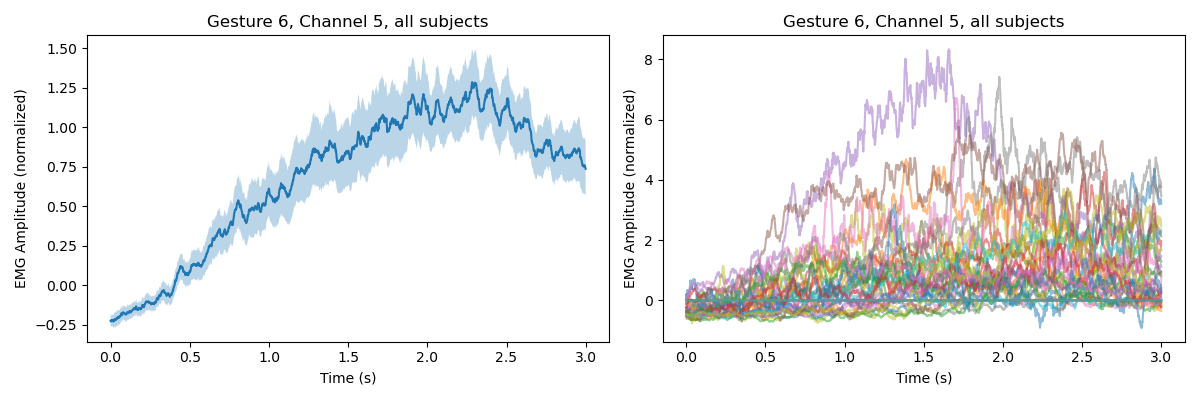

In [109]:
# Plot mean and sem of the emg across subjects
mean_emg = np.mean(emg_mean_subject, axis=0)
sem_emg = np.std(emg_mean_subject, axis=0) / np.sqrt(emg_mean_subject.shape[0])
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epoch_time, mean_emg, label='Mean EMG')
axs[0].fill_between(epoch_time, mean_emg - sem_emg, mean_emg + sem_emg, alpha=0.3, label='±1 SEM')
axs[0].set_title(f'Gesture {gesture_to_plot}, Channel {channel_to_plot}, all subjects')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('EMG Amplitude (normalized)')

# Plot all individual subject traces
for subject_number in range(1,41):
    axs[1].plot(epoch_time, emg_mean_subject[subject_number-1, :], alpha=0.5, label=f'Subject {subject_number}')
axs[1].set_title(f'Gesture {gesture_to_plot}, Channel {channel_to_plot}, all subjects')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('EMG Amplitude (normalized)') 
# plt.legend()
plt.tight_layout()
# if saveFigs:    
#     plt.savefig(parentDir / "results" / "figures" / f"emg_average_subject{subject_number}_exercise{exercise_number}_gesture{gesture_to_plot}_channel{channel_to_plot}.png", dpi=300)
plt.show()

In [108]:
# for repetition_id in range(1, 7):  #6 repetitions
#         # Find start and end indices of the gesture repetition
#         mask = (stimulus == gesture_id) & (repetition == repetition_id)
#         if np.any(mask):
#             start_idx = np.where(mask)[0][0]
#             end_idx = np.where(mask)[0][-1]
#             ## Skip spans that are completely outside the plotted window
#             if end_idx < start_index or start_idx > end_index - 1:
#                 continue
#             # Clamp to the plotting window
#             start_idx = max(start_idx, start_index)
#             end_idx   = min(end_idx,   end_index - 1)
#         axs[0].axvspan(time[start_idx], time[end_idx], color=plt.cm.tab20(gesture_id % 20), alpha=0.3, label=f' {gesture_id}')
#         axs[1].axvspan(time[start_idx], time[end_idx], color=plt.cm.tab20(gesture_id % 20), alpha=0.3, label=f' {gesture_id}')

In [ ]:
def create_epochs(emg_signal, stimulus, repetition, Fs, pre_stim=0, post_stim=1):
    """ Create epochs for each gesture and repetition based on stimulus and repetition markers."""
    unique_channels = emg_signal.shape[1] if len(emg_signal.shape) > 1 else 1
    unique_gestures = np.unique(stimulus)
    unique_repetitions = range(1,7)  # 6 repetitions

    # empty numpy array of size (number of gestures x number of repetitions)
    epochs = np.zeros((len(unique_gestures)*len(unique_repetitions), (post_stim-pre_stim)*Fs, unique_channels), dtype=object)
    print(epochs.shape)
    
    epoch_gesture_labels = np.zeros((len(unique_gestures)*len(unique_repetitions)), dtype=int)
    epoch_repetition_labels = np.zeros((len(unique_gestures)*len(unique_repetitions)), dtype=int)

    count = 0
    for gesture in unique_gestures:
        if gesture == 0:
            continue  # Skip rest
        for rep in unique_repetitions:
            indices = np.where((stimulus == gesture) & (repetition == rep))[0]
            if len(indices) == 0:
                continue
            start_idx = indices[0] - int(pre_stim * Fs)
            end_idx = indices[-1] + int(post_stim * Fs)
            if start_idx < 0 or end_idx > len(emg_signal):
                continue  # Skip if out of bounds
            epoch = emg_signal[start_idx:end_idx]
            print(np.shape(epoch))
            epochs[count, :, :] = epoch
            epoch_gesture_labels[count] = gesture
            epoch_repetition_labels[count] = rep
            count += 1
    return epochs, epoch_gesture_labels, epoch_repetition_labels

In [169]:
epochs, epoch_gesture_labels, epoch_repetition_labels = create_epochs(filtered_emg, stimulus, repetition, Fs)

(108, 2000, 1)
(10479,)


ValueError: could not broadcast input array from shape (10479,) into shape (2000,1)

In [159]:
epochs[0]

array([array([-0.45683313, -0.45639325, -0.45640732, ...,  0.24315752,
               0.24831822,  0.25331643], shape=(10479,))              ],
      dtype=object)

In [ ]:


emg_clean = np.zeros_like(emg)
for ch in range(emg.shape[1]):
    emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)
    for gesture in np.unique(stimulus):
        if gesture == 0:
            continue
        for rep in range(1, 7):
            mask = (stimulus == gesture) & (repetition == rep)
            if np.sum(mask) == 0:
                continue
            start_idx = np.where(mask)[0][0]
            end_idx = np.where(mask)[0][-1]



In [122]:
# Preprocess all channels
# Epoch the data based on stimulus and repetition information
emg_clean = np.zeros_like(emg)
for ch in range(emg.shape[1]):
    emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)
    # Epoching code would go here
    for gesture in np.unique(stimulus):
        if gesture == 0:
            continue  # Skip rest gesture
        gesture_indices = np.where(stimulus == gesture)[0]
        for repetition in range(1,7):  #6 repetitions
            repetition_indices = np.where(repetition == repetition)[0]
            epoch_indices = np.intersect1d(gesture_indices, repetition_indices)
            if len(epoch_indices) > 0:
                emg_epoch = emg_clean[epoch_indices, ch]
                # Store or process the epoch as needed
                # For example, you could append it to a list or save it to a file
                # epochs.append(emg_epoch)
                # Or you could compute features from the epoch
                # features = extract_features(emg_epoch, Fs)
                # Store features in a dictionary
                # feature_dict[(gesture, repetition)] = features


ValueError: Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.

In [ ]:
fs = 2000
win_s, step_s = 200, 100
win = int(fs * win_s / 1000)
step = int(fs * step_s / 1000)

X, y, reps = [], [], []

for g in np.unique(stimulus):
    for r in np.unique(repetition[stimulus == g]):
        idx = np.where((stimulus == g) & (repetition == r))[0]
        for i in range(0, len(idx)-win, step):
            seg = emg_clean[idx[i:i+win], :]
            if seg.shape[0] == win:
                X.append(seg)
                y.append(g)
                reps.append(r)

X, y, reps = np.array(X), np.array(y), np.array(reps)
print("X:", X.shape, "y:", y.shape, "reps:", np.unique(reps))


X: (8881, 400, 12) y: (8881,) reps: [0 1 2 3 4 5 6]
